# Top 4 European Leagues: Top scorer skills
## Turbine Chart 

In [10]:
## Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
from highlight_text import ax_text, fig_text

from PIL import Image
import urllib
import json
import os
import matplotlib.font_manager as fm
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap, NoNorm
from highlight_text import fig_text

from mplsoccer import Radar, FontManager, grid
import scipy.stats as stats

import math


gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)


font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")


In [11]:
## Minutes percentage table: preprocessing
df_passing = pd.read_csv('../data/big5_player_passing.csv', index_col='Ind')
df_possession = pd.read_csv('../data/big5_player_possession.csv', index_col='Ind')
df_shooting = pd.read_csv('../data/big5_player_shooting.csv', index_col='Ind')
df_std = pd.read_csv('../data/big5_player_std.csv', index_col='Ind')
passing_col = ['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90', 'Cmp_percent_Total', 'xAG' ]
possession_col = ['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90', 'Att Pen_Touches', 'Succ_Dribbles' ]
shooting_col = ['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90', 'xG_Expected', 'G_per_SoT_Standard', 'npxG_per_Sh_Expected']

df_total = pd.merge(df_passing[passing_col], df_possession[possession_col], on=['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90'], how='left')
df_total = pd.merge(df_total, df_shooting[shooting_col], on=['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90'], how='left')

df_fw = df_total.loc[df_total.Pos.isin(["FW", "MF,FW", "FW,MF", "FW,DF",  "DF, FW"]), :]
df_fw = df_fw.rename(columns={'Cmp_percent_Total':'Completed Pass %', 'xAG':'Expected Assisted Goals', 'Att Pen_Touches':'Attacking Penalty Area touches', 'Succ_Dribbles':"Successfull Dribbles",
       'xG_Expected':'Expected Goals', 'G_per_SoT_Standard':'Goal per Shoot on Target', 'npxG_per_Sh_Expected':'Non Penalty Expected Goal per Shoot'})

# UK filter
# Comp: Premier League
df_uk = df_fw.query('Comp=="Premier League"')
# ITA filter
# Comp: Serie A
df_it = df_fw.query('Comp=="Serie A"')
# ESP filter
# Comp: La Liga
df_es = df_fw.query('Comp=="La Liga"')
# GER filter
# Comp: La Liga
df_ge = df_fw.query('Comp=="Bundesliga"')


params = ['Completed Pass %', 'Expected Assisted Goals', 'Attacking Penalty Area touches', 'Successfull Dribbles',
       'Expected Goals', 'Goal per Shoot on Target', 'Non Penalty Expected Goal per Shoot']


In [12]:
low = df_uk[params].quantile(0.05).values
high = df_uk[params].quantile(0.95).values
#lower_is_better = ['Cmp_percent_Total']
radar = Radar(params, low, high, num_rings=4)
fm = FontManager()

In [13]:
def BuildRadar(df, player, team, team_color, league, goaltext, assisttext, params, c_map):
    # creating the figure using the grid function from mplsoccer:
    fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar', axis=False)

    # plot the turbine plot
    radar.setup_axis(ax=axs['radar'])
    # plot the turbine blades. Here we give the player_Values and
    # the value for all players shape=(1000, 11)
    player_values = df.loc[df.Player == player, params].values[0]
    turbine_output = radar.turbine(player_values, df[params].values, ax=axs['radar'], kwargs_inner={'edgecolor': 'black'},
                                    kwargs_inner_gradient={'cmap': c_map}, kwargs_outer={'facecolor': '#b2b2b2', 'edgecolor': 'black'})
    # plot some dashed rings and the labels for the values and parameter names
    rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='None',
                                 edgecolor='black', linestyle='--')
    range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=15,
                                       fontproperties=fm.prop, zorder=1)
    param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=15,
                                       fontproperties=fm.prop, zorder=1)

    # adding a title and endnote
    title1_text = axs['title'].text(0.01, 0.65, player, fontsize=25,
                                    fontproperties=fm.prop, ha='left', va='center')
    title2_text = axs['title'].text(0.01, 0.25, team, fontsize=20,
                                    fontproperties=fm.prop, ha='left', va='center', color=team_color)
    title3_text = axs['title'].text(0.99, 0.65, goaltext, fontsize=25,
                                    fontproperties=fm.prop, ha='right', va='center')
    title4_text = axs['title'].text(0.99, 0.25, assisttext, fontsize=20,
                                    fontproperties=fm.prop, ha='right', va='center')
    endnote_text1 = axs['endnote'].text(0.12, 0.5, league, fontsize=15,
                                        fontproperties=fm.prop, ha='right', va='center')
    endnote_text2 = axs['endnote'].text(0.99, 0.5, 'Data from Opta via FBref', fontsize=15,
                                        fontproperties=fm.prop, ha='right', va='center')


In [14]:
TopScorer = ['Erling Haaland', 'Victor Osimhen', 'Robert Lewandowski', 'Christopher Nkunku']
GoalT = ['Goal: 18', 'Goal: 8', 'Goal: 13', 'Goal: 11']
AssistT = ['Assist: 3', 'Assist: 2', 'Assist: 4', 'Assist: 0']
Team = ['Manchester City', 'Napoli', 'Barcelona', 'RB Leipzig']
Colors = ['#6CABDD', '#12A0D7', '#EDBB00', '#EC1845']
Leagues = ['Premier L.', 'Serie A', 'La Liga', 'Bundesliga']
C_Map = ['Blues', 'PuBu', 'BuPu', 'Reds']
TeamId = [8456, 9875, 8634, 178475]
df_list = [df_uk, df_it, df_es, df_ge]

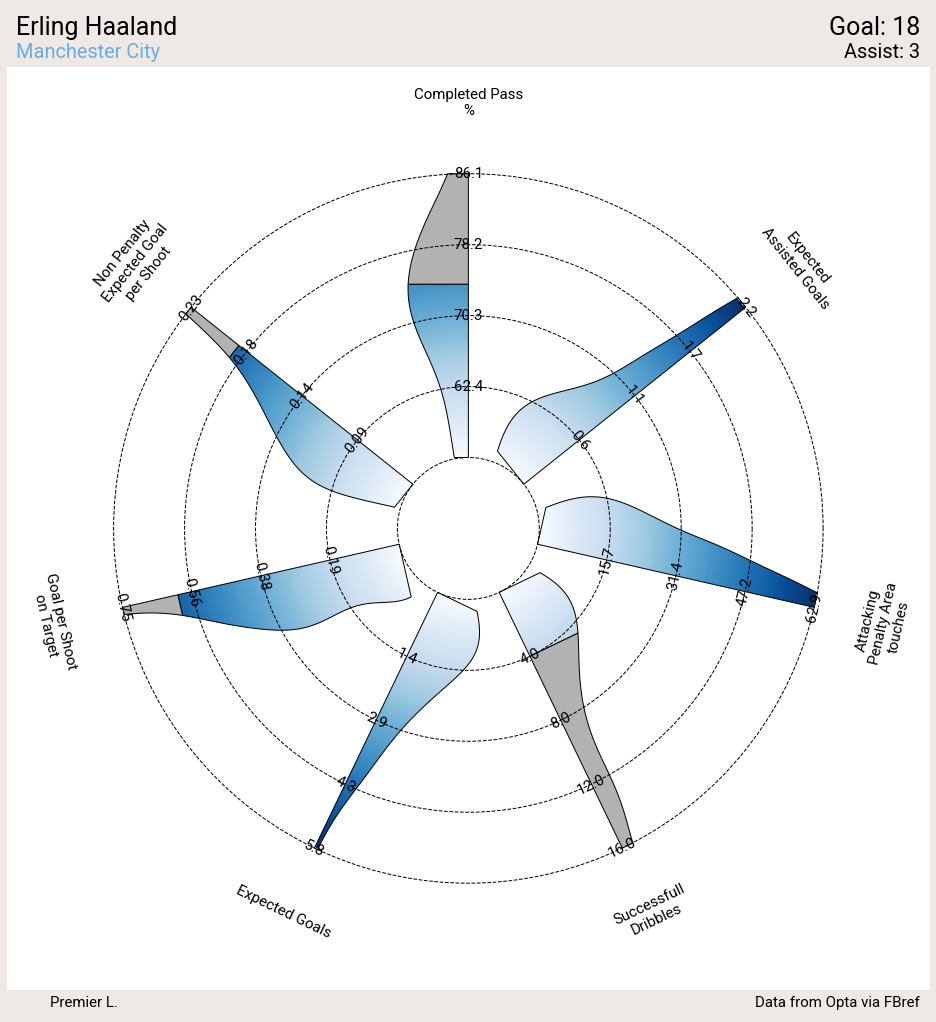

In [15]:
BuildRadar(df_list[0], TopScorer[0], Team[0], Colors[0], Leagues[0], GoalT[0], AssistT[0], params, C_Map[0])

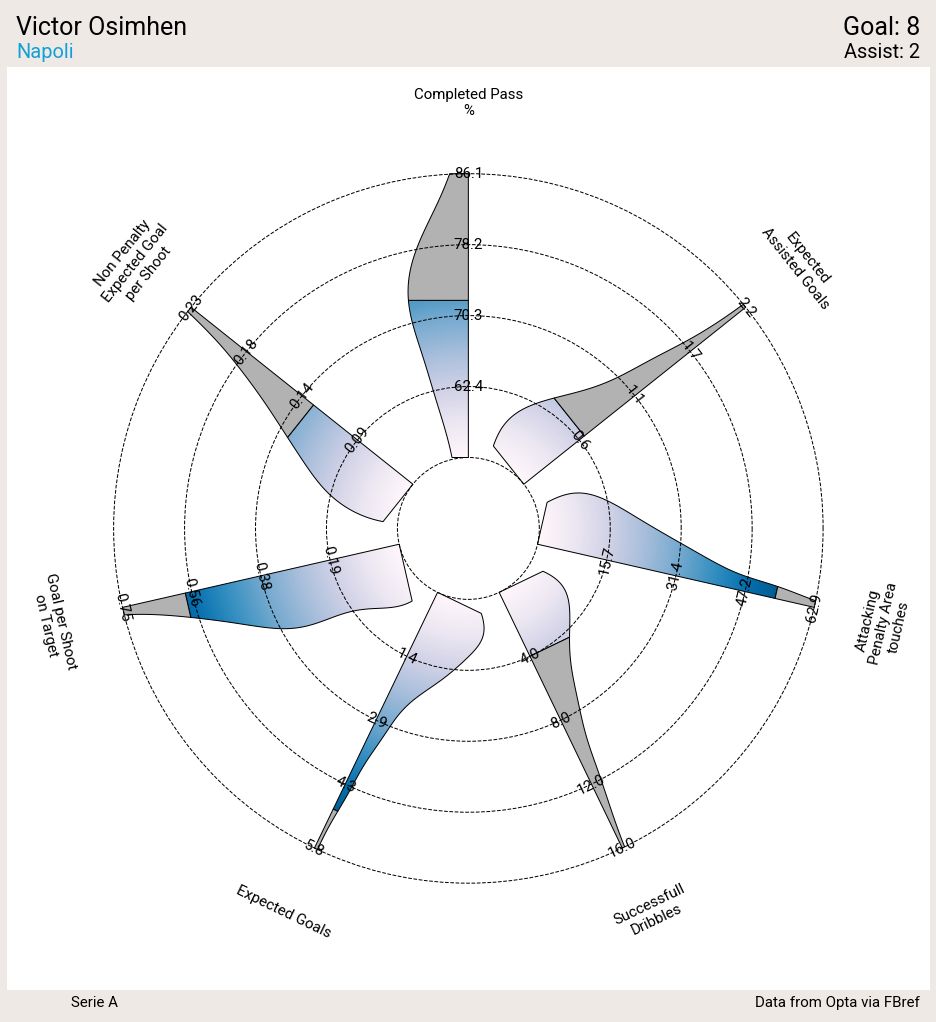

In [16]:
BuildRadar(df_list[1], TopScorer[1], Team[1], Colors[1], Leagues[1], GoalT[1], AssistT[1], params, C_Map[1])

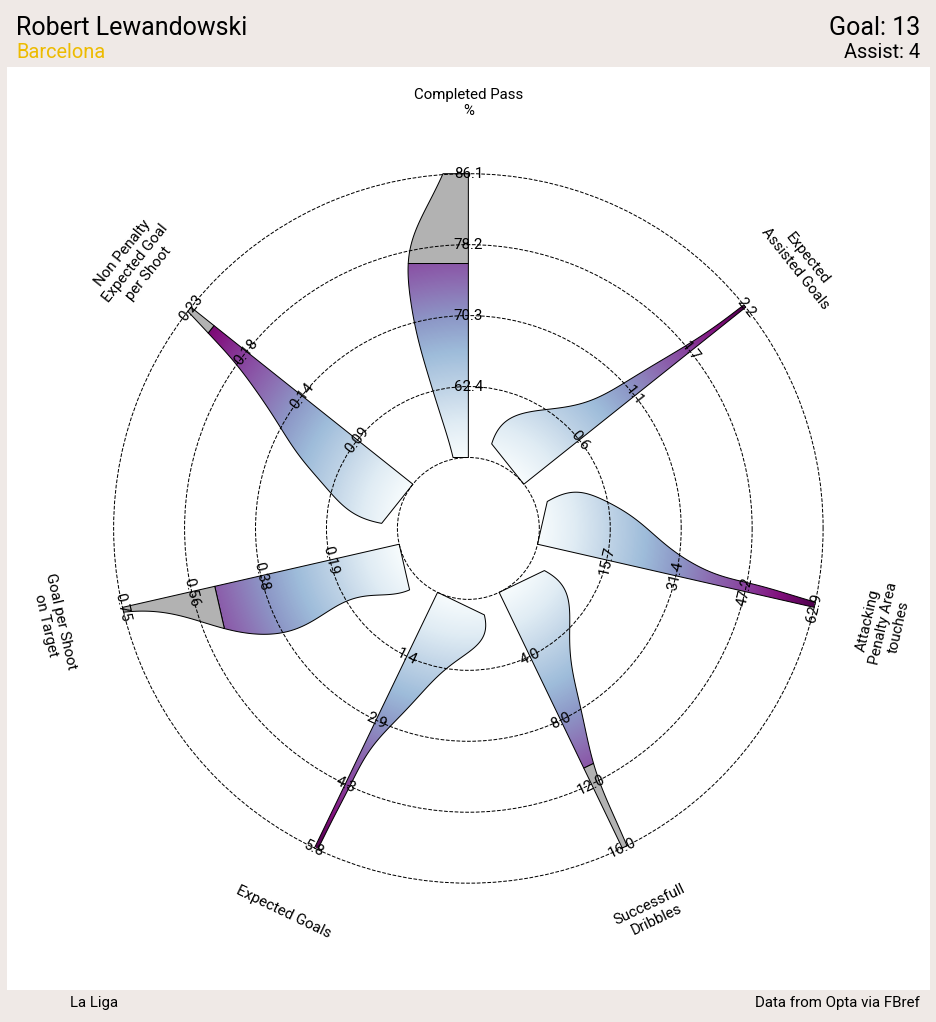

In [17]:
BuildRadar(df_list[2], TopScorer[2], Team[2], Colors[2], Leagues[2], GoalT[2], AssistT[2], params, C_Map[2])

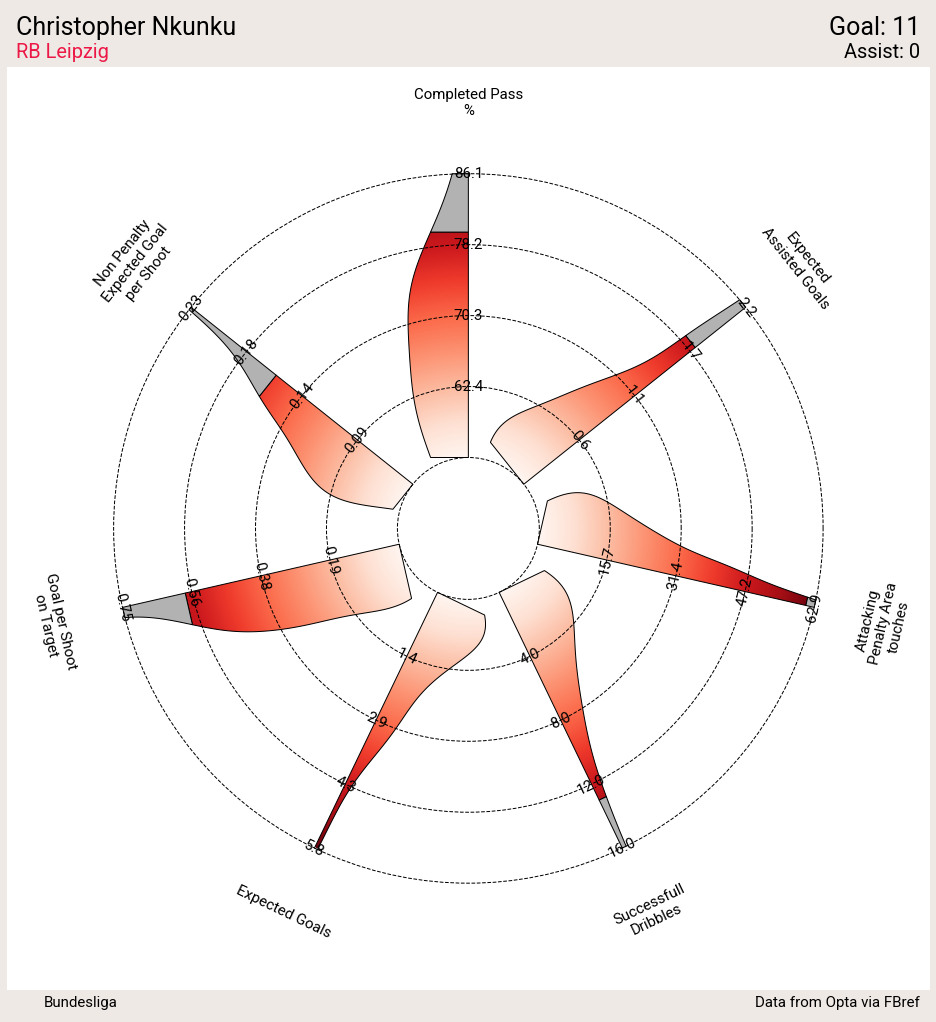

In [18]:
BuildRadar(df_list[3], TopScorer[3], Team[3], Colors[3], Leagues[3], GoalT[3], AssistT[3], params, C_Map[3])